# System Identification

In [1]:
using Rocket, ReactiveMP, GraphPPL, Distributions, StableRNGs

In [2]:
rng = StableRNG(42)

# generate data
n = 250

real_x = Vector{Float64}(undef, n)
real_w = Vector{Float64}(undef, n)
real_y = Vector{Float64}(undef, n)

real_x_τ = 0.1
real_w_τ = 1.0

x_i_min = -20.0
w_i_min = 20.0

for i in 1:n
    real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
    real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
    real_y[i] = rand(rng, Normal(real_x[i] + real_w[i], sqrt(1.0 / 1.0)))
    
    x_i_min = real_x[i]
    w_i_min = real_w[i]
end

In [3]:
@model function identification_problem(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w)
    
    x0 ~ NormalMeanPrecision(m_x_0, τ_x_0)
    τ_x ~ GammaShapeRate(a_x, b_x)
    w0 ~ NormalMeanPrecision(m_w_0, τ_w_0)
    τ_w ~ GammaShapeRate(a_w, b_w)
    
    x = randomvar(n)
    w = randomvar(n)
    s = randomvar(n)
    y = datavar(Float64, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x[i] ~ NormalMeanPrecision(x_i_min, τ_x)
        w[i] ~ NormalMeanPrecision(w_i_min, τ_w)
        s[i] ~ x[i] + w[i]
        y[i] ~ NormalMeanPrecision(s[i], 1.0)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
    return x, w, y, τ_x, τ_w
end

In [4]:
constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)
end;

In [5]:
m_x_0, τ_x_0 = -20.0, 1.0
m_w_0, τ_w_0 = 20.0, 1.0

a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)

imessages = (x = NormalMeanPrecision(m_x_0, τ_x_0), w = NormalMeanPrecision(m_w_0, τ_w_0))
imarginals = (τ_x = GammaShapeRate(a_x, b_x), τ_w = GammaShapeRate(a_w, b_w))

result = inference(
    model = Model(identification_problem, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w),
    data  = (y = real_y,), 
    options = model_options(limit_stack_depth = 100,),
    constraints = constraints, 
    initmessages = imessages, 
    initmarginals = imarginals, 
    iterations = 100, 
    showprogress = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [6]:
τ_x_marginals, τ_w_marginals = result.posteriors[:τ_x], result.posteriors[:τ_w]

xmarginals, wmarginals = result.posteriors[:x], result.posteriors[:w];

In [7]:
mean.(τ_x_marginals)[end], mean.(τ_w_marginals)[end]

(0.1017547451202951, 0.4984583837534951)

In [8]:
using Plots

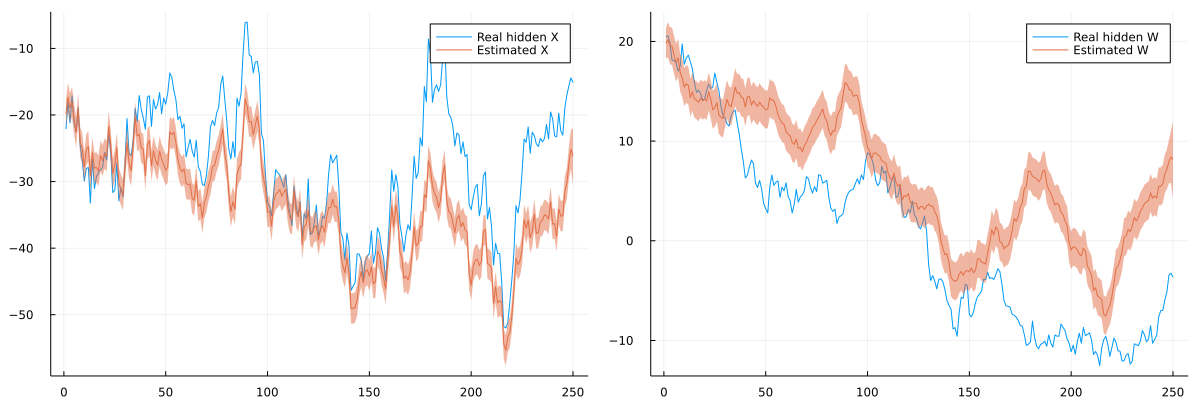

In [9]:
px1 = plot()
px2 = plot()

px1 = plot!(px1, real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(xmarginals[end]), ribbon = var.(xmarginals[end]), label = "Estimated X")

px2 = plot!(px2, real_w, label = "Real hidden W")
px2 = plot!(px2, mean.(wmarginals[end]), ribbon = var.(wmarginals[end]), label = "Estimated W")

plot(px1, px2, size = (1200, 400))

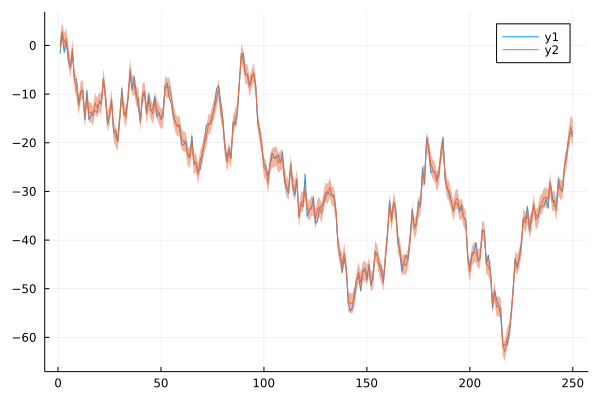

In [10]:
p = plot()

p = plot!(p, real_x .+ real_w)
p = plot!(p, mean.(xmarginals[end]) + mean.(wmarginals[end]), ribbon = (var.(xmarginals[end]) + var.(wmarginals[end])) .|> sqrt)